In [158]:
import src.utilis.network_analysis as na
import src.data.dataFunctions as dl
import src.utilis.utilis as ut
import src.utilis.plotting as pl 
import pandas as pd
from IPython.display import display
import numpy as np
import warnings
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load and Prepare Data
First, we load all the necessary data files using our custom processing function. This function handles reading the CSVs, cleaning subreddit names, and filtering the datasets based on the list of approved subreddits.

In [160]:
COUNTRY_FILE = "data/country_matches_map_exp.csv"  
EMBEDDINGS_FILE = "data/web-redditEmbeddings-subreddits.csv" 
TITLE_FILE = "data/soc-redditHyperlinks-title.tsv"
BODY_FILE = "data/soc-redditHyperlinks-body.tsv"        


df_countries=dl.load_country_subreddits(COUNTRY_FILE)
df_embeddings=dl.load_embeddings(EMBEDDINGS_FILE)
df_posts=dl.load_post_data(TITLE_FILE, BODY_FILE)
df_post_with_1_country, df_post_between_countries=dl.filter_posts_by_country(df_posts, df_countries)

print(f"\nLoaded {len(df_countries)} approved country-related subreddits.")
print(f"Loaded {len(df_embeddings)} embeddings.")
print(f"Loaded {len(df_post_with_1_country)} posts with at least one approved country-related subreddit.")
print(f"Loaded {len(df_post_between_countries)} posts between approved country-related subreddits.")

Loading approved subreddits from: data/country_matches_map_exp.csv
Loading embeddings from: data/web-redditEmbeddings-subreddits.csv
Loading and combining post data...
Filtering posts by country and enriching data...

Loaded 3195 approved country-related subreddits.
Loaded 51278 embeddings.
Loaded 81395 posts with at least one approved country-related subreddit.
Loaded 12308 posts between approved country-related subreddits.


# Familiarizing ourselves with the main dataset (df_posts)

### Description of variables in the dataset

SOURCE_SUBREDDIT: the subreddit where the link originates

TARGET_SUBREDDIT: the subreddit where the link ends

POST_ID: the post in the source subreddit that starts the link

TIMESTAMP: time time of the post

POST_LABEL: label indicating if the source post is explicitly negative towards the target post. 

The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. 

The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.

POST_PROPERTIES: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:

01. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER
22. LIWC_Funct
23. LIWC_Pronoun
24. LIWC_Ppron
25. LIWC_I
26. LIWC_We
27. LIWC_You
28. LIWC_SheHe
29. LIWC_They
30. LIWC_Ipron
31. LIWC_Article
32. LIWC_Verbs
33. LIWC_AuxVb
34. LIWC_Past
35. LIWC_Present
36. LIWC_Future
37. LIWC_Adverbs
38. LIWC_Prep
39. LIWC_Conj
40. LIWC_Negate
41. LIWC_Quant
42. LIWC_Numbers
43. LIWC_Swear
44. LIWC_Social
45. LIWC_Family
46. LIWC_Friends
47. LIWC_Humans
48. LIWC_Affect
49. LIWC_Posemo
50. LIWC_Negemo
51. LIWC_Anx
52. LIWC_Anger
53. LIWC_Sad
54. LIWC_CogMech
55. LIWC_Insight
56. LIWC_Cause
57. LIWC_Discrep
58. LIWC_Tentat
59. LIWC_Certain
60. LIWC_Inhib
61. LIWC_Incl
62. LIWC_Excl
63. LIWC_Percept
64. LIWC_See
65. LIWC_Hear
66. LIWC_Feel
67. LIWC_Bio
68. LIWC_Body
69. LIWC_Health
70. LIWC_Sexual
71. LIWC_Ingest
72. LIWC_Relativ
73. LIWC_Motion
74. LIWC_Space
75. LIWC_Time
76. LIWC_Work
77. LIWC_Achiev
78. LIWC_Leisure
79. LIWC_Home
80. LIWC_Money
81. LIWC_Relig
82. LIWC_Death
83. LIWC_Assent
84. LIWC_Dissent
85. LIWC_Nonflu
86. LIWC_Filler

LIWC - linguistic inquiry and word count (codebook: https://www.liwc.app/static/documents/LIWC-22%20Manual%20-%20Development%20and%20Psychometrics.pdf)

### 1. Look at the dataset

In [161]:
display(df_posts.head())

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,num_chars,num_chars_no_space,frac_alpha,frac_digits,frac_upper,frac_spaces,frac_special,num_words,num_unique_words,num_long_words,avg_word_length,num_unique_stopwords,frac_stopwords,num_sentences,num_long_sentences,avg_chars_per_sentence,avg_words_per_sentence,readability_index,sent_pos,sent_neg,sent_compound,LIWC_Funct,LIWC_Pronoun,LIWC_Ppron,LIWC_I,LIWC_We,LIWC_You,LIWC_SheHe,LIWC_They,LIWC_Ipron,LIWC_Article,LIWC_Verbs,LIWC_AuxVb,LIWC_Past,LIWC_Present,LIWC_Future,LIWC_Adverbs,LIWC_Prep,LIWC_Conj,LIWC_Negate,LIWC_Quant,LIWC_Numbers,LIWC_Swear,LIWC_Social,LIWC_Family,LIWC_Friends,LIWC_Humans,LIWC_Affect,LIWC_Posemo,LIWC_Negemo,LIWC_Anx,LIWC_Anger,LIWC_Sad,LIWC_CogMech,LIWC_Insight,LIWC_Cause,LIWC_Discrep,LIWC_Tentat,LIWC_Certain,LIWC_Inhib,LIWC_Incl,LIWC_Excl,LIWC_Percept,LIWC_See,LIWC_Hear,LIWC_Feel,LIWC_Bio,LIWC_Body,LIWC_Health,LIWC_Sexual,LIWC_Ingest,LIWC_Relativ,LIWC_Motion,LIWC_Space,LIWC_Time,LIWC_Work,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,345.0,298.0,0.756522,0.017391,0.086957,0.150725,0.075362,57.0,53.0,10.0,4.789474,15.0,0.315789,1.0,1.0,345.000000,57.000000,35.577895,0.073,0.080,0.1748,0.344828,0.051724,0.034483,0.000000,0.034483,0.000000,0.000000,0.0,0.017241,0.051724,0.103448,0.051724,0.000000,0.103448,0.000000,0.034483,0.034483,0.068966,0.017241,0.034483,0.000000,0.0,0.103448,0.000000,0.0,0.000000,0.051724,0.017241,0.034483,0.000000,0.000000,0.017241,0.189655,0.034483,0.0,0.034483,0.034483,0.000000,0.000000,0.068966,0.051724,0.034483,0.034483,0.000000,0.0,0.017241,0.017241,0.0,0.0,0.0,0.068966,0.017241,0.051724,0.000000,0.051724,0.068966,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,101.0,98.0,0.742574,0.019802,0.049505,0.059406,0.178218,14.0,14.0,2.0,5.714286,1.0,0.071429,2.0,0.0,49.500000,7.000000,16.049286,0.472,0.000,0.5538,0.066667,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066667,0.066667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,85.0,85.0,0.752941,0.023529,0.082353,0.011765,0.211765,10.0,10.0,2.0,7.200000,0.0,0.000000,1.0,0.0,85.000000,10.000000,23.605000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,1124.0,949.0,0.772242,0.001779,0.057829,0.179715,0.046263,191.0,125.0,34.0,4.623037,36.0,0.366492,15.0,9.0,73.200000,12.733333,12.654154,0.153,0.026,0.9672,0.526042,0.109375,0.041667,0.031250,0.000000,0.005208,0.010417,0.0,0.067708,0.057292,0.151042,0.098958,0.015625,0.083333,0.036458,0.052083,0.109375,0.052083,0.010417,0.046875,0.005208,0.0,0.067708,0.010417,0.0,0.000000,0.052083,0.041667,0.010417,0.010417,0.000000,0.000000,0.203125,0.046875,0.0,0.036458,0.046875,0.015625,0.005208,0.036458,0.031250,0.015625,0.010417,0.000000,0.0,0.005208,0.005208,0.0,0.0,0.0,0.104167,0.015625,0.052083,0.036458,0.026042,0.031250,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.005208
4,playmygame,gamede

We can see that the DataFrame of all the posts contains the source and target of each post as well as several properties related to the posts themselves. 

### 2. Look at the total number of unique subreddits and posts

In [162]:
# Combine both source and target columns into a single Pandas Series
all_subreddits_series = pd.concat([df_posts['SOURCE_SUBREDDIT'], df_posts['TARGET_SUBREDDIT']])

# Get the unique values from this combined series and convert to a list
unique_subreddit_list = all_subreddits_series.unique().tolist()
print(f"Found {len(unique_subreddit_list)} unique subreddits.")

# Display the total number of posts in the dataset
total_posts = len(df_posts)
print(f"Found {total_posts} posts.")

Found 67180 unique subreddits.
Found 858488 posts.


### 3. Study the average properties of outgoing posts of the different subreddits

In [163]:
# First get subreddit counts
subreddit_counts = df_posts["SOURCE_SUBREDDIT"].value_counts()

# Keep only subreddits with at least 20 posts
valid_subreddits = subreddit_counts[subreddit_counts >= 20].index

# Now compute averages for those
avg_props_by_subreddit = (
    df_posts[df_posts["SOURCE_SUBREDDIT"].isin(valid_subreddits)]
    .groupby("SOURCE_SUBREDDIT")[ut.post_props_cols]
    .mean()
)

display(avg_props_by_subreddit.head())

,num_chars,num_chars_no_space,frac_alpha,frac_digits,frac_upper,frac_spaces,frac_special,num_words,num_unique_words,num_long_words,avg_word_length,num_unique_stopwords,frac_stopwords,num_sentences,num_long_sentences,avg_chars_per_sentence,avg_words_per_sentence,readability_index,sent_pos,sent_neg,sent_compound,LIWC_Funct,LIWC_Pronoun,LIWC_Ppron,LIWC_I,LIWC_We,LIWC_You,LIWC_SheHe,LIWC_They,LIWC_Ipron,LIWC_Article,LIWC_Verbs,LIWC_AuxVb,LIWC_Past,LIWC_Present,LIWC_Future,LIWC_Adverbs,LIWC_Prep,LIWC_Conj,LIWC_Negate,LIWC_Quant,LIWC_Numbers,LIWC_Swear,LIWC_Social,LIWC_Family,LIWC_Friends,LIWC_Humans,LIWC_Affect,LIWC_Posemo,LIWC_Negemo,LIWC_Anx,LIWC_Anger,LIWC_Sad,LIWC_CogMech,LIWC_Insight,LIWC_Cause,LIWC_Discrep,LIWC_Tentat,LIWC_Certain,LIWC_Inhib,LIWC_Incl,LIWC_Excl,LIWC_Percept,LIWC_See,LIWC_Hear,LIWC_Feel,LIWC_Bio,LIWC_Body,LIWC_Health,LIWC_Sexual,LIWC_Ingest,LIWC_Relativ,LIWC_Motion,LIWC_Space,LIWC_Time,LIWC_Work,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler
SOURCE_SUBREDDIT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100daysofrejection,38.066667,31.600000,0.621454,0.129779,0.132037,0.195114,0.053653,7.466667,7.422222,0.866667,3.874983,1.266667,0.162092,1.000000,0.044444,38.066667,7.466667,6.568442,0.000000,0.357067,-0.469993,0.143260,0.011642,0.011642,0.011642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108333,0.000000,0.108333,0.000000,0.000000,0.108333,0.023284,0.000000,0.000000,0.000000,0.011642,0.000000,0.000000,0.011642,0.000000,0.000000,0.000000,0.000000,0.000000,0.011642,0.000000,0.011642,0.000000,0.000000,0.251593,0.000000,0.011642,0.239951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100movies365days,1877.361111,1673.722222,0.702896,0.047292,0.022451,0.114269,0.135543,271.777778,148.888889,49.222222,5.485169,29.861111,0.296716,13.361111,11.666667,142.655438,20.318556,22.177776,0.061667,0.038972,0.189528,0.350576,0.085858,0.038323,0.009876,0.003241,0.023275,0.001680,0.000612,0.047535,0.039842,0.102629,0.075290,0.012782,0.051424,0.019336,0.017942,0.085266,0.030247,0.000547,0.013464,0.005341,0.000103,0.083786,0.001491,0.000084,0.007216,0.028258,0.015886,0.012314,0.001225,0.008186,0.000910,0.083376,0.020138,0.004202,0.014881,0.020403,0.005977,0.000904,0.021126,0.012623,0.017062,0.014115,0.001433,0.001201,0.004770,0.004272,0.000161,0.000337,0.000000,0.089739,0.012605,0.026609,0.050455,0.027111,0.002299,0.052544,0.000252,0.000546,0.000576,0.001099,0.000537,0.000245,0.000775,0.000757
13point1,84.125000,71.375000,0.774844,0.012727,0.124862,0.156525,0.055904,14.000000,13.250000,3.541667,5.078941,2.791667,0.169754,1.666667,0.458333,54.569444,8.854167,13.241525,0.019250,0.028958,-0.012654,0.294423,0.038708,0.025463,0.013488,0.002778,0.005229,0.005381,0.000000,0.013246,0.035668,0.042573,0.027093,0.011388,0.027217,0.001984,0.022169,0.074443,0.007002,0.000706,0.008281,0.091143,0.000000,0.026353,0.000000,0.001984,0.000706,0.014499,0.006314,0.008185,0.000000,0.000000,0.005208,0.034230,0.007395,0.000000,0.001984,0.005983,0.005591,0.000000,0.014967,0.002309,0.004167,0.004167,0.000000,0.000000,0.012573,0.003682,0.008891,0.000706,0.000000,0.217945,0.096250,0.044373,0.077322,0.028276,0.030635,0.173018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002451,0.000000
195,148.000000,129.320000,0.781407,0.008233,0.181420,0.147186,0.063175,25.480000,16.920000,3.840000,4.554260,3.960000,0.261372,2.560000,0.820000,49.311270,8.675198,9.745509,0.081140,0.039820,0.113784,0.309874,0.110016,0.063778,0.051147,0.000380,0.011319,0.001758,0.000176,0.046238,0.034187,0.078971,0.036712,0.043086,0.031453,0.003333,0.039767,0.059061,0.024258,0.004117,0.010988,0.004230,0.007136,0.040086,0.000040,0.000000,0.004056,0.042079,0.030259,0.0117

Let's look at different textual properties to understand how they are related to subreddit titles

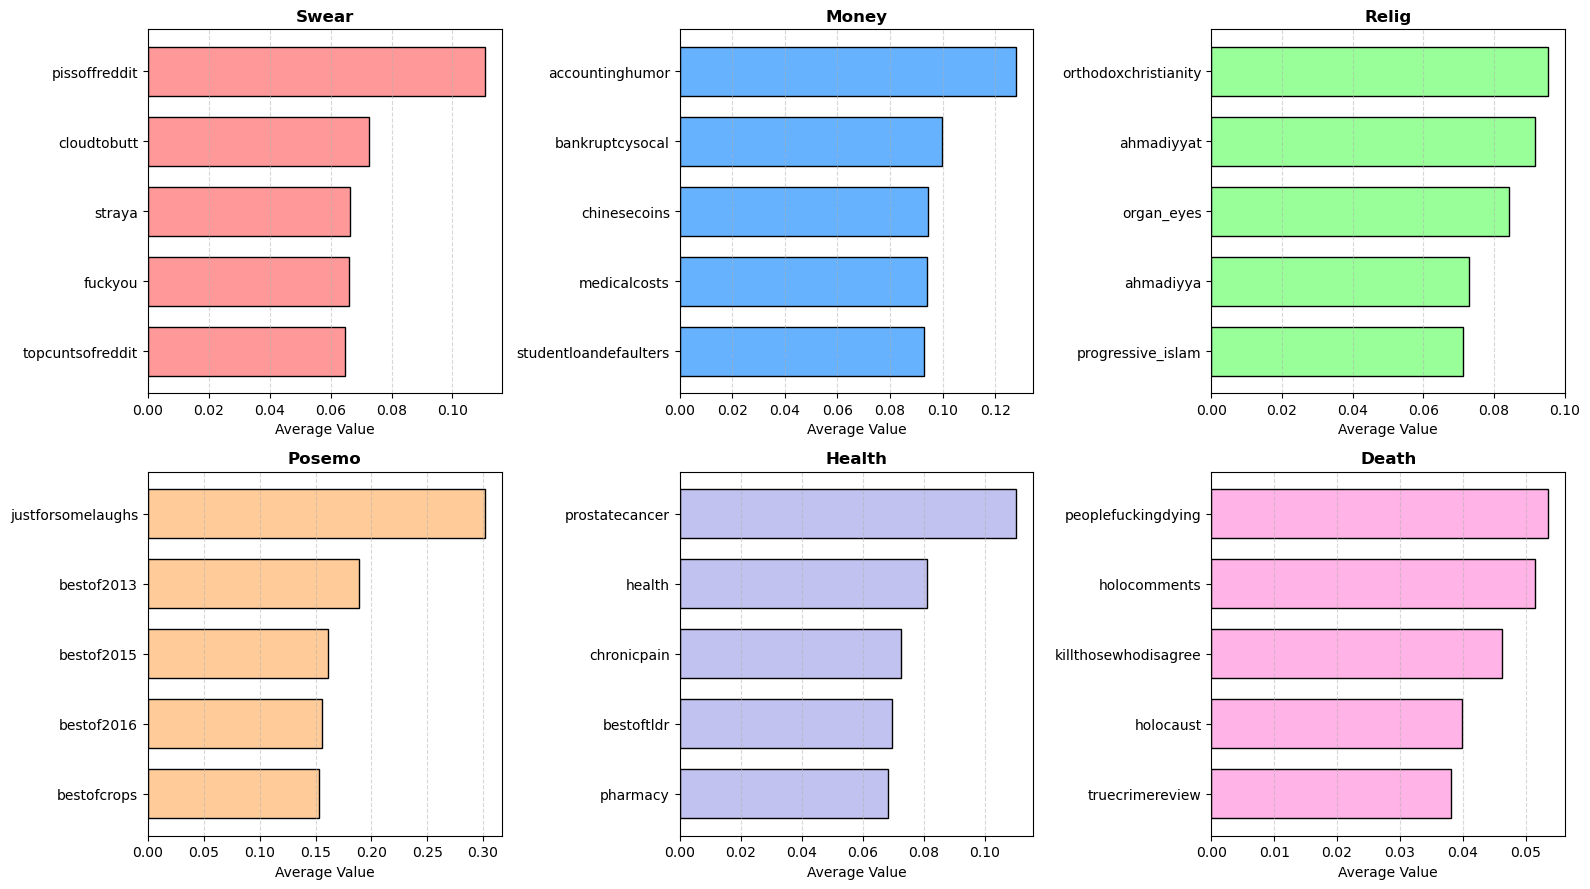

In [164]:
target_metrics = [
    'LIWC_Swear', 'LIWC_Money', 'LIWC_Relig', 
    'LIWC_Posemo', 'LIWC_Health', 'LIWC_Death'
]

pl.plot_top_5_subreddits(avg_props_by_subreddit, target_metrics)

We can clearly see that for general textual properties (e.g. Health, Money, ...) there is a clear link between the subreddit title and the arguments of the outgoing posts. This incourage us to conduct an analysis using subreddit names as variables, still having in mind that this could be a biased analysis

# Clusters based on embeddings

### 1. Prepare Data
First, we'll use a function from our `utilis` module to separate the subreddit names from the embedding vectors and scale the vectors. This scaling step is essential for clustering algorithms to work correctly.

In [165]:
scaled_data, subreddit_labels = ut.prepare_embeddings_for_clustering(df_embeddings)

Data prepared: 51278 items, 300 features.


### 2. Find Optimal Number of Clusters (k)

We can't just guess how many clusters to create. We'll run a K-Means "Elbow Analysis" on a sample of the data.

**How to Read This Plot:** Look for the "elbow" of the arm, the point where the line starts to flatten out. This point is usually a good choice for the number of clusters. Adding more clusters after this point gives diminishing returns.

  Testing k=10...
  Testing k=50...
  Testing k=100...
  Testing k=150...
  Testing k=200...
  Testing k=250...
  Testing k=300...
  Testing k=500...
  Testing k=700...
  Testing k=800...
  Testing k=1000...


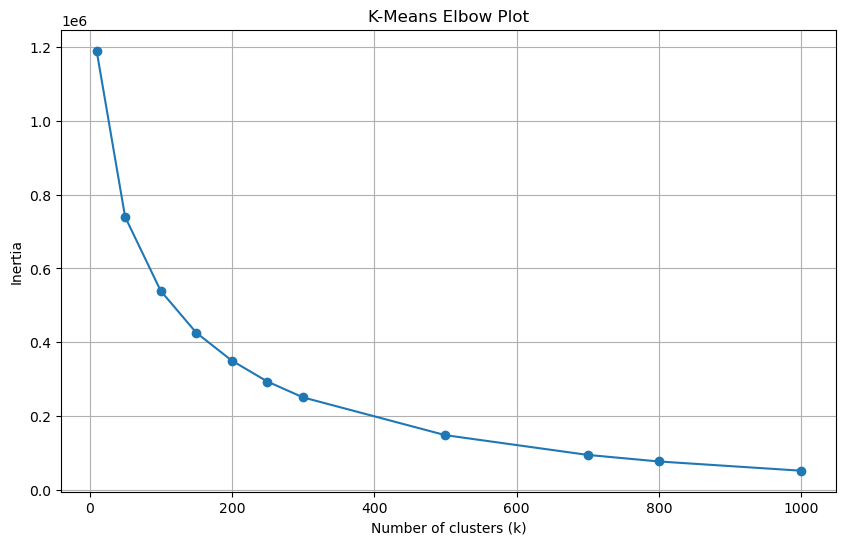

In [166]:
# This will take few minutes to run
k_value_list=[10, 50, 100, 150, 200, 250, 300, 500, 700, 800, 1000]

elbow_df = ut.calculate_kmeans_elbow_wide(scaled_data, k_value_list, n_samples=5000)

pl.plot_kmeans_elbow(elbow_df)

### 3. Run Final Clustering & Visualization

Now, looking at the elbow plot above we can choose k=200. 

This function will:
1.  Run the final K-Means clustering on the **full 50k+ dataset**.
2.  Run **t-SNE**, a powerful algorithm that reduces the 300+ dimensions down to 2D (x, y) so we can plot them.
3.  Create an interactive scatter plot.

In [167]:
N_CLUSTERS = 200  # number of clusters
MIN_SIZE = 300     # minimum size requirement of each cluster
PERPLEXITY = 50   

tsne_df, all_cluster_labels = ut.run_clustering_and_tsne(
    scaled_data, 
    subreddit_labels, 
    n_clusters=N_CLUSTERS,
    min_cluster_size=MIN_SIZE,
    perplexity=PERPLEXITY  
)

Running K-Means clustering with k=200 on 51278 items...
Finding valid clusters with > 300 members...
Found 24 valid clusters (out of 200) meeting the size criteria.
Running t-SNE with perplexity=50... (sampling 15000 items)
t-SNE complete.


### 4. Manually Label Clusters

Now we'll inspect the clusters. The cell below will get a sample of subreddits from all valid clusters.

In [168]:
valid_clusters = set(tsne_df['cluster'].astype(int))

# Build the full dataframe of all subreddits and their cluster IDs
full_df = pd.DataFrame({
    'subreddit': subreddit_labels,
    'cluster': all_cluster_labels
})
    
# Filter this full dataframe to only include subreddits in valid clusters
valid_df = full_df[full_df['cluster'].isin(valid_clusters)]
    
# Get samples from our valid clusters
cluster_samples = ut.get_cluster_samples(
    valid_df['subreddit'].values,
    valid_df['cluster'].values,
    n_samples=100  # Show 100 samples from each
)
    
# Print the samples for inspection
for cluster_id, subs in cluster_samples.items():
        print(f"\n--- Cluster {cluster_id} ---")
        print(subs)


--- Cluster 0 ---
['rescuedogs', 'starblecch', 'savagegarden', 'holdmycatnip', 'casualtodayilearned', 'herpetology', 'mildlystartledcats', 'israelimossad', 'spainpics', 'gifsthatendtoosoon', 'bestofworldstar', 'darkfacts', 'thehobbit', 'themartian', 'palatecleanser', 'girlsinagif', 'dinosaurs', 'onejob', 'adiposeamigos', 'nzphotos', 'babyelephants', 'doowop', 'whereisthis', 'hitmanimals', 'simpsonsdidit', 'desertporn', 'southampton', 'beforenafteradoption', 'adirondacks', 'rubberducks', 'artisangifts', 'sharks', 'raafaircraft', 'kailua96734', 'turtle', 'wince', 'startrekgifs', 'simulated', 'serialkillers', 'boop', 'cat', 'inspirationscience', 'soposts', 'landscapeastro', 'warships', 'panda', 'ecards', 'holdmyjuicebox', 'lolcats', 'selfies', 'corgigifs', 'oldschoolcelebs', 'scottishphotos', 'bsg', 'amateurearthporn', 'birdsbeingdicks', 'awwtf', 'megamanlounge', 'educationanimated', 'butterflies', 'squirrels', 'doggifs', '90scartoons', 'europics', 'brokengifs', 'marinebiologygifs', 'bro

We can now use an LLM to give a meaningful labl to each cluster in order to have an understanding plot

In [169]:
label_map = {
    # --- HIGH CLARITY: Distinct Topics ---
    '0': 'Animals, Nature & Visual Media',
    '5': 'Hardcore NSFW & Porn',
    '23': 'Explicit NSFW & Fetish',
    '35': 'Politics, News & Social Issues',
    '46': 'Celebrities & Fan Appreciation',
    '55': 'Radical Politics, Conspiracy & Debate',
    '104': 'Academia, Science & Humanities',
    '126': 'Marketing, Business & SEO',
    '155': 'Video Games & Consoles',
    '160': 'eSports, MMOs & Game Trading',

    # --- MEDIUM CLARITY: Broader Themes ---
    '8': 'Memes, Circlejerk & Shitposting',
    '42': 'Advice, Support & Local Communities',
    '63': 'Health, Fitness & Women\'s Interest',
    '74': 'Tech, Software & Media',
    '107': 'Pop Culture, TV & Internet Humor',
    '114': 'Gay Interest, Male Physique & NSFW',
    '145': 'YouTubers, Streamers & Let\'s Play',

    # --- LOW CLARITY: Mixed, Spam, or "Junk" Clusters ---
    '4': 'Mixed NSFW, Crypto & Spam',
    '11': 'General Interest, Hobbies & Advice (Mixed)',
    '32': 'Spam Bots, Names & Niche NSFW',
    '80': 'Spam, Scams & Niche Gaming',
    '136': 'Hookups, Streams & News Feeds',
    '138': 'Self-Promo, Giveaways & Tech Hacks',
    '199': 'Mixed General Interest (Jobs/Tech/NSFW)'
}

# --- Now, we plot using the assigned labels ---

pl.plot_labeled_cluster_map(tsne_df, label_map)


From this interactive plot we can see that many clusters are not specifically related to one single topic while others strictly relate to one. Let's procede to analyse geographical connections.

# Country analysis

# CHANGE
To understand country-specific interactions, we first needed to identify which subreddits belong to which countries. We use two different sets of country mappings at different stages:

1. The Approved List (Used First)
Generation: An initial automated mapping was created (in make_initial_subreddit_maps.ipynb and filter_matches.ipynb). This found obvious matches (e.g., brasilonreddit -> Brazil) but also incorrect ones (e.g., askinsurance -> France).

Verification: This initial list was manually reviewed, and each match was either "approved" or "rejected".

Usage: For the first part of our analysis, we use only this manually approved list to ensure high accuracy.

2. The Expanded List (Used Later)
Generation: Later in this notebook, we introduce a new, much larger list of subreddit-to-country mappings. This list also includes matches made based on states and cities and linkes them to the relevant country. 

Verification: This expanded list is a raw, automated output and has not been manually approved yet. (We plan to verify this list at a later time).

Usage: We use this unapproved list for the second part of our analysis to explore broader trends with a larger dataset, accepting that it contains unverified data.

### 1. Map subreddits to the country they belong to and look at their average properties
Here we can conduct a similar analysis to the previous one but just considering country-related subreddit 

In [170]:
# At the beginning we loaded all the posts containg a country related subreddit either as source or as target
# Here we keep only the posts with a source subreddit categorized as a country
df_post_source_country = df_post_with_1_country.dropna(subset=['source_country'])

# First, get post counts per country 
country_post_counts = df_post_source_country["source_country"].value_counts()

# Keep only countries with at least 20 posts 
min_posts_threshold = 20
valid_countries = country_post_counts[country_post_counts >= min_posts_threshold].index

print(f"Found {len(valid_countries)} countries with at least {min_posts_threshold} posts.")

# Now compute averages for those countries
# We filter the DataFrame first, then groupby
avg_props_by_country = (
    df_post_source_country[df_post_source_country["source_country"].isin(valid_countries)]
    .groupby("source_country")[ut.post_props_cols] 
    .mean()
)

Found 62 countries with at least 20 posts.


In [171]:
metric = "LIWC_Relig"
title="Average Religion Sentiment by Country"

pl.plot_countries_by_metric(avg_props_by_country, metric, title)

The ranking of countries by "Religion" sentiment provides strong validation for the methodology of classifying subreddits by country using the name. The results align with real-world geopolitical and cultural realities:

The highest-ranked countries (Israel, Saudi Arabia, Palestine, Morocco, and Indonesia) are nations where religion is either a central pillar of daily life or a primary driver of political discourse. 
The Bottom of the Ranking: Conversely, the presence of historically secular or irreligious nations like Czechia and Estonia at the bottom of the list confirms that the metric is successfully differentiating between religious and secular linguistic patterns.

It is important to acknowledge that specific rankings may appear as outliers due to the inherent nature of the data source

For countries in the middle-end of the ranking, the difference in scores is often microscopic (e.g., a difference of 0.0001). In these cases, the specific ranking order is less meaningful and likely fluctuates based on random noise or transient topics.
However, the top-ranked nations show scores that are distinctively higher—often double or triple the average of the bottom tier. Despite the raw numbers being small, this relative difference is statistically significant. It confirms that for these specific communities, religion is not just background noise but a recurring and measurable theme of the conversation.

### 2. Country interactions

Let's look at the raw post count originating from each country's subreddits to understand general activity levels. Here we are using the larger list of country mappings that have not been manually approved yet.

In [172]:
display(country_post_counts.head(20))

source_country
USA               18437
Canada             4490
Japan              2600
India              2284
Australia          1566
France             1510
Italy              1423
United Kingdom     1182
Ireland            1155
Brazil             1081
Norway              836
Netherlands         782
China               748
Sweden              686
Portugal            681
Argentina           677
Germany             573
Russia              553
Romania             537
Greece              509
Name: count, dtype: int64

We can clearly see that there is a big difference in the number of posts associated to each country so it is recommended to normalized every country by the number of posts

In [173]:
df_final= ut.calculate_normalized_interactions(country_post_counts, df_post_between_countries)

display(df_final[['Country_A', 'Country_B', 'n_interactions', 'norm_log']].head(20))

,Country_A,Country_B,n_interactions,norm_log
417,Israel,Palestine,122,19.204646
564,Russia,Ukraine,78,11.553670
136,Canada,USA,105,10.458048
340,India,Pakistan,74,9.466765
589,USA,United Kingdom,78,7.891299
101,Brazil,Portugal,49,6.555384
395,Iran,USA,64,6.499636
300,Germany,USA,60,6.089656
411,Ireland,USA,57,5.767522
138,Canada,United Kingdom,42,4.859158


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
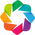

:Chord   [source,target]   (value)

In [174]:
viz=pl.chord_plot(df_final)
viz

Based on these results, the mappings appear to be highly relevant and effective.

The top-ranking interactions are not random. They clearly reflect significant real-world relationships:

Geographic & Cultural Neighbors: The high volume of interactions between the United States and Canada, as well as between India and Pakistan, highlights strong regional and cultural connections (and rivalries).

Geopolitical Hotspots: The prominent ranking of pairs like Iran and the United States, and Israel and Palestine, strongly indicates that the mappings are successfully capturing communities engaged in intense, real-world geopolitical discourse.

Linguistic & Historical Ties: The presence of USA/UK and Brazil/Portugal further validates the mappings by identifying well-known historical and linguistic connections.

In conclusion, the fact that the aggregated data mirrors known global relationships so closely serves as a strong validation. It shows the approved mapping list is successfully identifying distinct country-specific communities and capturing their most significant online interactions.

### 3. Faction Analysis using Embeddings
We have previously seen that creating cluster using the embedding can lead to confuse results, that's why this analysis attempts to find "strict" subreddits (those that are semantically closer to their own country's subreddits than to any other) and their closest neighbors based on embedding distance. 


In [175]:
# find only the embedding of country-related subreddits
df_embeddings_countries=dl.filter_embeddings_by_country(df_embeddings, df_countries)

# keep only the strict links
df_strict = ut.find_strict_subreddits(df_countries, df_embeddings_countries)

print(f"Found {len(df_strict)} 'strict' subreddits.")
print("\nTop 10 countries by number of 'strict' subreddits:")
display(df_strict.groupby("country").size().sort_values(ascending=False).head(10))

Filtering embeddings...
Embedding filtering complete.
Found 154 'strict' subreddits.

Top 10 countries by number of 'strict' subreddits:


country
Ireland         16
India           12
Belgium          7
USA              7
Ukraine          6
Brazil           6
Denmark          6
Mexico           6
Portugal         5
South Africa     5
dtype: int64

In [176]:
# we search for the closest subreddit (cosine similarity on embedding vectors) categorized as a different country 
closest_df = ut.find_closest_dissimilar_subreddits(df_strict, df_embeddings)
print("\nClosest subreddits from different countries (based on embedding distance):")
display(closest_df.head(10))


Closest subreddits from different countries (based on embedding distance):


,subreddit,country,most_similar_subreddit,most_similar_country,similarity_score
0,sweden,Sweden,brasilivre,Brazil,0.332446
1,brasil,Brazil,portugal,Portugal,0.533895
2,romania,Romania,portugal,Portugal,0.496943
3,ireland,Ireland,ukraina,Ukraine,0.296048
4,argentina,Argentina,chile,Chile,0.371436
5,newzealand,New Zealand,saudiarabia,Saudi Arabia,0.440420
6,ukraina,Ukraine,suomi,Finland,0.362714
7,israel,Israel,palestine,Palestine,0.639630
8,portugal,Portugal,brasil,Brazil,0.533895
9,mexico,Mexico,romania,Romania,0.252619


As we can see performing the analysis on embedding distance is not leading us to correct results even when considering only subreddit strongly related to countries. The closest subreddit always belong to a country that is not geographical/cultural/political related.

### 4. Faction Analysis using Positive Posts

This is a more robust analysis. It builds a network graph where countries are nodes. The edge weight is based on the number of positive posts, normalized by the total activity of each country. This normalization prevents large countries (like Canada or USA) from dominating all factions simply due to high post volume.

This method helps identify strong communities (factions) based on *relative* interaction patterns.

In [177]:
factions_summary_norm, factions_df_norm = ut.detect_normalized_factions(df_post_between_countries)
pl.plot_faction_world_map(factions_df_norm, title="World Map of Factions")

There are few conclusion we can state from this plot:
- Significant Data Gaps: The vast grey areas in Central Africa, Central Asia, and parts of South America highlight a severe "digital divide," confirming Reddit’s bias toward English-speaking and Western-aligned nations; countries that are colored but have low post counts are statistically unstable and may be grouped based on "noise" rather than deep cultural ties.

- The "Eurasian" Conflict Zone: Russia anchors a massive Blue bloc that pulls in Eastern Europe, suggesting that political discourses mathematically isolate these nations from the rest of the European cluster.

- Economic Reality Over Culture: Australia clustering with China (Green) rather than the USA or UK is a major outlier that suggests trade relations and geopolitical tension define their online relationship more than shared Western culture.

- The Indo-Middle Eastern Nexus: India shares a cluster (Red) with Saudi Arabia, Iran, and Turkey, accurately reflecting real-world dynamics and regional proximity that differentiate them from the "East Asian" or "Western" spheres.

- Fractured Americas: The Americas are not a monolith; Brazil acts as an isolated linguistic island, while Canada and Mexico (Orange) cluster together separate from the USA (Purple).

- Linguistic connections: A link between Brazil-Portugal and India-UK is evidence on how much the linguisitc feature mtter when using the hyperlink metric for the creation of the factions

Now, we analyze how factions change from year to year using the source-normalized method.

In [178]:
df_post_between_mapped = ut.map_countries_to_posts(df_post_between_countries, df_countries, period="Y")

y_factions_norm_df = ut.analyze_source_normalized_factions_over_time(df_post_between_mapped)
pl.plot_faction_evolution(y_factions_norm_df)

Of course from this plot we can't understand which country belong to which faction and also the faction's number and color are just used to distinguish them. The plot is usefull to visually understand how the states migrate between the factions, especially during the lat year.

In order to have a better perspective on the countries that switched group we can analyze the evolution using a finer split of time and then look at the most stable couples

Which countries consistently appear in the same faction together over time? A high fraction means a strong, stable bond.

In [179]:
df_post_between_mapped = ut.map_countries_to_posts(df_post_between_countries, df_countries, period="Q")

q_factions_norm_df = ut.analyze_source_normalized_factions_over_time(df_post_between_mapped)
stable_pairs_norm = ut.find_stable_pairs(q_factions_norm_df)
print("Most Stable Country Pairs (Source-Normalized):")
display(stable_pairs_norm.head(15))

Most Stable Country Pairs (Source-Normalized):


,country1,country2,quarters_together,fraction_quarters_together
0,Russia,Ukraine,13,0.928571
1,India,Pakistan,12,0.857143
2,Brazil,Portugal,11,0.785714
3,Croatia,Serbia,10,0.714286
4,Australia,New Zealand,10,0.714286
5,Indonesia,Malaysia,10,0.714286
6,Malaysia,Singapore,10,0.714286
7,China,South Korea,9,0.642857
8,North Korea,South Korea,9,0.642857
9,Denmark,Norway,9,0.642857


We have a validation of the results obtained with the individual analysis but from a different persective


Let's visualize the results for some countries. 

An heatmap indicating the number of quarters spent together is a good choice, having in mind that of course the matrix is symmetric and reach the maximum along the main diagonal.
We are interested in the brighter squares outside of the diagonal

In [180]:
target_countries = [
    'USA', 'Canada', 'Japan', 'India', 'Australia', 'France', 'Italy',
    'United Kingdom', 'Ireland', 'Brazil', 'Norway', 'Netherlands', 'China',
    'Sweden', 'Portugal', 'Argentina', 'Germany', 'Russia', 'Romania',
    'Greece', 'Mexico', 'Iran', 'New Zealand', 'Israel', 'Serbia',
    'Denmark', 'Philippines', 'Peru', 'Estonia', 'Poland', 'South Korea',
    'Finland', 'Ukraine', 'Spain', 'Singapore', 'Turkey',
    'Croatia', 'Latvia', 'Indonesia', 'Belgium', 'Austria', 'Colombia',
    'Pakistan', 'Malaysia', 'Palestine', 'Switzerland', 'Iceland', 'Chile'
    ]

pl.heatmap_co_occurrence(target_countries, q_factions_norm_df)

#### Loyalty Score
Which countries tend to switch factions most often? A low score means the country frequently changes its primary allies.

In [181]:
loyalty_norm = ut.calculate_loyalty_scores(q_factions_norm_df)
print("Most 'Loyal' Countries (Most likely to stay with the same allies, Score < 1.0):")
display(loyalty_norm.sort_values("loyalty_score", ascending=False).head(15))

Most 'Loyal' Countries (Most likely to stay with the same allies, Score < 1.0):


,country,loyalty_score,total_quarters
0,Russia,0.928571,14
1,Ukraine,0.928571,14
2,Pakistan,0.923077,13
3,Portugal,0.916667,12
4,India,0.857143,14
5,Brazil,0.846154,13
6,North Korea,0.818182,11
7,Singapore,0.769231,13
8,Malaysia,0.714286,14
9,New Zealand,0.714286,14


### 5.Signed Network Visualization
Finally, let's visualize the overall network. This graph shows the net sentiment (positive posts - negative posts) between all countries.

- **Nodes** are colored by the faction they belong to (from the normalized analysis).
- **Green Edges** = Net Positive Interaction
- **Red Edges** = Net Negative Interaction
- **Edge Width** = Total number of posts (log-scaled)

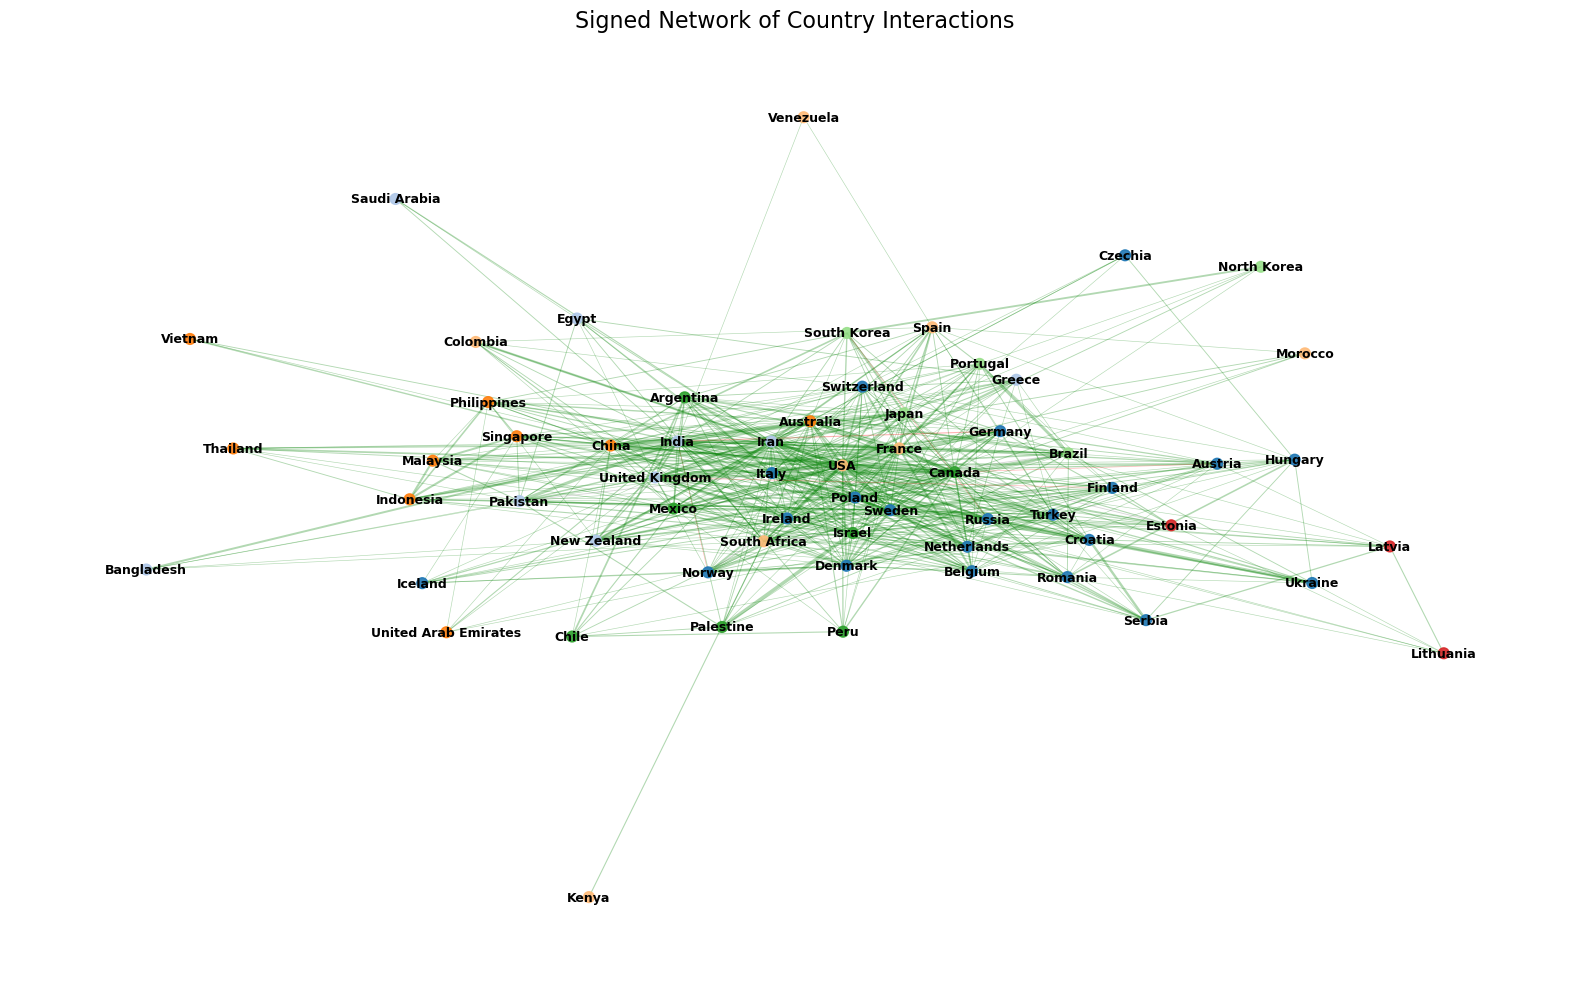

In [182]:
pl.plot_signed_network(
    df_post_between_countries, 
    factions_df_norm, 
    title="Signed Network of Country Interactions"
)

We can clearly see that biggest states are in the middle and are the vertices of many edges reflecting their user's community activity.

The block of states belonging to the biggest faction create an intricated network in the middle of the graph. 

Overall the meajority of the edges are green showing that our dataset is clearly unbalanced towards positive labelled posts


# Global Conditional Probability of Reciprocity

In simple terms, we want to answers the question:
> "If Country A posts to Country B, what is the probability that Country B will post back to Country A within 7 days?"

## Function Analysis: `response_global`

### 1. Preparation and Filtering

* **Clean:** Drops any rows where the source or target country is missing, and converts the `TIMESTAMP` column into a proper datetime format.
* **Create `pair_key`:** To analyze a pair like (Italy, France), it needs to group all `Italy -> France` and `France -> Italy` interactions together. It uses a `frozenset` because `frozenset({'Italy', 'France'})` is the *same* as `frozenset({'France', 'Italy'})`. This lets it group all interactions for a pair, regardless of direction.
* **Filter `valid_pairs`:** It counts how many interactions each pair has. If a pair only has one post (e.g., Italy posted to France, but France *never* posted), it's impossible to measure reciprocity. So, it only keeps pairs with 2 or more interactions.

### 2. The Deterministic Logic 

* **Loop:** It loops through every `valid_pair` (e.g., the `{'Italy', 'France'}` pair).
* **Find the "True" Initiator:** For each pair, it gets all their interactions and finds the **very first post** (`first_interaction = df_pair.iloc[0]`).
* **Assign Roles:** Based on that *first post*, it permanently assigns the roles:
    * `country_A` = The `SOURCE_COUNTRY` of that very first post (The "Initiator").
    * `country_B` = The `TARGET_COUNTRY` of that very first post (The "Responder").
* **Separate Data:** It then creates two new DataFrames:
    * `df_A_to_B`: All posts where the Initiator (A) posted to the Responder (B).
    * `df_B_to_A`: All posts where the Responder (B) posted back to the Initiator (A).

### 3. The 7-Day Window (The `merge_asof`)

* **`pd.merge_asof`:** This is a powerful time-series function. It takes *every single post* from `df_A_to_B` (an "initiation") and searches in `df_B_to_A` to find the **first response** that happened *after* it (`direction='forward'`).
* **Calculate `response_time`:** It creates a new column by subtracting the initiation time from the response time.
* **Check Window:** It checks if this `response_time` is less than or equal to 7 days.
* **Count Totals:**
    * `total_initiators_global` is incremented by the total number of initiations (the length of `df_A_to_B`).
    * `total_responses_global` is incremented only by the number of responses that were `True` for the 7-day check.

### 4. Final Calculation

* It divides `total_responses_global` by `total_initiators_global` to get the final conditional probability (e.g., `P(B->A | A->B)`).
* It prints this final result.

In [58]:
ut.response_global(df_post_between_countries)

DataFrame ready. Analyzing 446 pairs.


Analyzing pairs: 100%|██████████| 446/446 [00:00<00:00, 997.34it/s] 


--- Global Reciprocity Analysis ---
Total 'initiator' interactions (A->B) analyzed: 1454
Total responses (B->A) within 7 days: 266
GLOBAL Conditional Probability P(B->A | A->B in 7d): 18.29%


# Conditional Probability of Reciprocity within the same country

In simple terms, we want to answers the question:
> "If a post from Subreddit A is directed to Subreddit B (both in the same country), what is the probability that Subreddit B will post back to Subreddit A within 7 days?"

## Function Analysis: `response_intra_country`

## 1. Preparation and Filtering

* **Clean & Filter:** It only keeps rows where `SOURCE_COUNTRY` and `TARGET_COUNTRY` are the same (and not null), AND where `SOURCE_SUBREDDIT` is different from `TARGET_SUBREDDIT`.
* **Create `pair_key`:** Just like the global function, it uses a `frozenset` to group subreddit pairs (e.g., `frozenset({'r/news', 'r/politics'})`).
* **Filter `valid_pairs`:** It only keeps pairs of subreddits that have interacted 2 or more times.

## 2. The Deterministic Logic 

* **Loop:** It loops through every `valid_pair` (e.g., the `{'r/news', 'r/politics'}` pair).
* **Find the "True" Initiator:** For each pair, it gets all their interactions (which are already sorted by time) and finds the **very first post** (`first_interaction = df_pair.iloc[0]`).
* **Assign Roles:** Based on that *first post*, it permanently assigns the roles:
    * `Sub_A` = The `SOURCE_SUBREDDIT` of that first post (The "Initiator").
    * `Sub_B` = The `TARGET_SUBREDDIT` of that first post (The "Responder").
* **Separate Data:** It creates two DataFrames:
    * `df_A_to_B`: All posts from Subreddit A to Subreddit B.
    * `df_B_to_A`: All posts from Subreddit B back to Subreddit A.

## 3. The 7-Day Window (The `merge_as_of`)

This is where the 7-day probability is calculated.

* **`pd.merge_asof`:** It takes *every single post* from `df_A_to_B` (an "initiation") and searches in `df_B_to_A` to find the **first response** that happened *after* it (`direction='forward'`).
* **Count Totals:** It counts how many initiations (`total_initiators_global`) and how many valid responses within 7 days (`total_responses_global`) were found.

## 4. Final Calculation

* It divides the total responses by the total initiations to get the final conditional probability.
* It prints this final result.

In [59]:
ut.response_intra_country(df_post_between_countries)

Found 9439 intra-country interactions (between different subreddits).
Analyzing 836 unique subreddit pairs.


Analyzing subreddit pairs: 100%|██████████| 836/836 [00:00<00:00, 1161.04it/s]


--- Global INTRA-COUNTRY Reciprocity Analysis ---
Total 'initiator' interactions (SubA -> SubB) analyzed: 3730
Total responses (SubB -> SubA) within 7 days: 273
GLOBAL Conditional Probability P(SubB->SubA | SubA->SubB in 7d): 7.32%


# Linguistic Style Mirroring Test

We want to answer the question:
> "When a post (A) triggers a reply (B), does the *style* of the reply (B) unconsciously mimic the *style* of the original post (A)?"

To prove this, we can't just measure the similarity of reply pairs. We need to prove that they are *more similar than they would be by pure chance*. This requires a:

1.  **Test Group:** A list of similarity scores from *actual* reciprocal pairs (A replied to B).
2.  **Control Group:** A list of similarity scores from *randomly selected* pairs (X and Y, who have no connection).
3.  **Comparison:** A statistical test (like a T-test) to see if the Test Group's similarity is significantly higher than the Control Group's.

This experimental design is complex. To keep the code clean and readable, we split the logic:

* **`find_reciprocity_pairs_and_similarity()` (The "Helper" Function):** This function has one very specific and difficult job: to find every valid `A -> B => B -> A` interaction and return the list of their similarity scores. This will be our **Test Group**.
* **`response_similarity()` (The "Main" Function):** This function acts as the "orchestrator." It defines the experiment, calls the helper function to get the Test Group, creates the **Control Group** itself, and then performs the final statistical comparison and visualization.

---
## The Helper Function: `find_reciprocity_pairs_and_similarity`

This function builds our **Test Group**.

1.  **Define Triggers (A) and Responses (B):**
    * It loads the `matches_csv` to get a list of "country subreddits."
    * A **"Trigger" (A)** is defined as any *non-country* subreddit posting *to* a *country* subreddit.
    * A **"Response" (B)** is defined as a *country* subreddit posting *to* a *non-country* subreddit.

2.  **Index Responses (An Optimization):**
    * Instead of re-scanning the entire list of responses for every single trigger, it creates a `response_lookup` dictionary. This index allows it to instantly find all potential responses for a given pair (e.g., all posts from `'r/italy'` to `'r/formula1'`).

3.  **Iterate and Find Pairs:**
    * It loops through *every single Trigger (A)* post.
    * For each trigger (e.g., `r/formula1 -> r/italy`), it calculates the 7-day window *from that post's timestamp*.
    * It uses the `response_lookup` to find all matching Responses (B) (e.g., `r/italy -> r/formula1`) that fall *within that 7-day window*.

4.  **Calculate Similarity:**
    * If valid responses are found, it takes the **first** one (`.iloc[0]`).
    * It gets the "style vector" (the list of 12 LIWC/VADER features) for the trigger post (A) and the response post (B).
    * It calculates the **cosine similarity** between these two vectors.
    * This similarity score is added to the `similarity_scores` list.

This function returns the complete `similarity_scores` list, which is our **Test Group**.

---
## The Main Function: `response_similarity`

This function takes the Test Group from the helper and runs the full experiment.

1.  **Define Style Vector:** It defines `style_features_list`. This is a crucial choice: we are *only* testing style (tone, pronouns, etc.), not the *topic* (work, money, etc.).
2.  **Prepare Data:** Filters it down to only the columns needed for the style vectors.
3.  **Get Test Group:** It calls `find_reciprocity_pairs_and_similarity()` to get the list of scores (`reciprocity_similarities`).
4.  **Create Control Group:**
    * It counts how many scores are in the Test Group (e.g., `N = 1,500`).
    * It then creates a `baseline_similarities` list by **randomly sampling** `N` pairs of posts from the *entire dataset* and calculating their similarity. This list represents the similarity that occurs "by pure chance."
5.  **Run Statistical Tests:**
    * It compares the two lists (`Reciprocal` vs. `Random`) using a T-test and a Mann-Whitney U-test.
    * It specifically uses `alternative='greater'` to test our hypothesis: "Is the Reciprocal group's similarity *greater than* the Random group's?"
6.  **Interpret Results & Plot:**
    * It checks the **p-value**. A `p < 0.05` is considered a **significant result**, meaning the similarity we see in the Test Group is not just a random fluke. This provides evidence for our "Stylistic Mirroring" hypothesis.
    * It then plots both distributions on a KDE plot, allowing us to *visually* confirm if the Reciprocal group's curve is shifted to the right (more similar) than the Random group's curve.

Analysis DataFrame ready.


100%|██████████| 42344/42344 [01:36<00:00, 436.56it/s] 



--- Starting Baseline Analysis (Control Group) ---
Creating 1960 random post pairs for comparison...


100%|██████████| 1960/1960 [00:00<00:00, 12583.32it/s]


Baseline analysis complete.

--- Statistics (Test Group: Reciprocal) ---
count    1960.000000
mean        0.273181
std         0.620153
min        -0.998335
25%         0.000000
50%         0.000000
75%         0.988670
max         1.000000
Name: Reciprocal, dtype: float64

--- Statistics (Control Group: Random) ---
count    1960.000000
mean        0.044441
std         0.548920
min        -0.987510
25%         0.000000
50%         0.000000
75%         0.003384
max         1.000000
Name: Random, dtype: float64

--- T-Test (Reciprocal > Random) ---
T-statistic: 12.2276
P-value: 0.0000

--- Mann-Whitney U Test (Reciprocal > Random) ---
U-statistic: 2375432.0000
P-value: 0.0000

--- Test Interpretation ---
SIGNIFICANT RESULT (p < 0.05):
The linguistic style of reciprocal response posts is SIGNIFICANTLY MORE SIMILAR
than that of two random posts. There is evidence of stylistic mirroring.


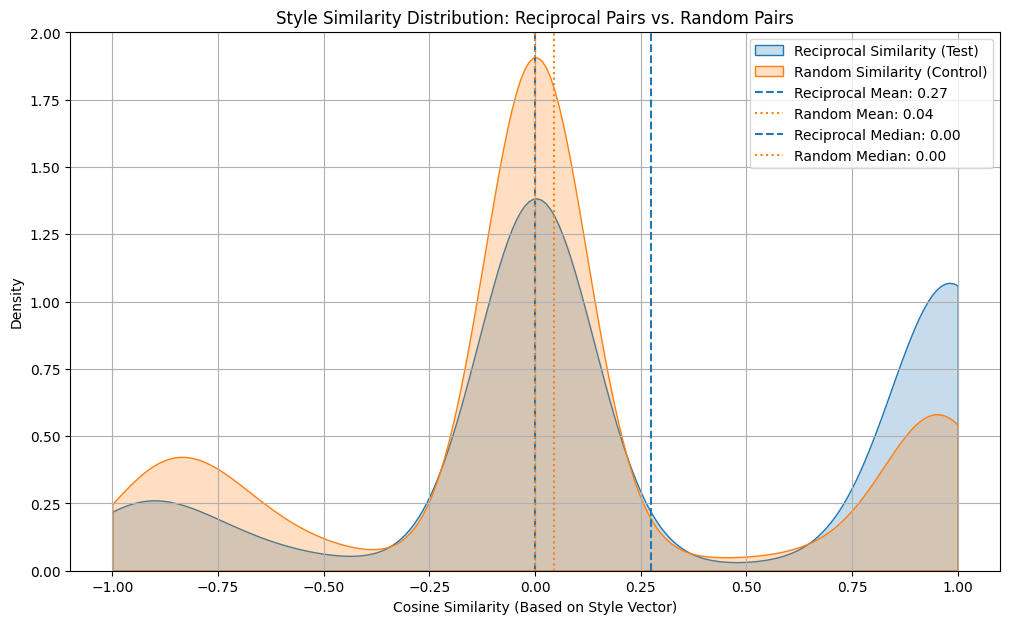

In [24]:
ut.response_similarity(df_posts, df_countries)

### Statistical Interpretation of Results

The t-test ($p < 0.05$) confirms that the mean style similarity for **Reciprocal pairs ($M=0.273$)** is **significantly higher** than for **Random pairs ($M=0.028$)**.

This difference in means is particularly notable because the **median similarity for both groups is identical (0.00)**.

The Kernel Density Estimate (KDE) plot explains this:

* The distribution for the Reciprocal (Test) group is **bimodal**.
* It shares the large central peak at 0.00 with the control group, indicating that the *majority* of interactions in both groups show no stylistic matching.
* However, the Reciprocal group features a **second, distinct peak near +1.0** (high similarity) which is absent in the control group.

### Conclusion

The data does not suggest that *all* reciprocal interactions involve mirroring.

Instead, it provides strong evidence that a **distinct subgroup of reciprocal posts exhibits extreme stylistic matching**. This specific subgroup is responsible for "pulling" the test group's mean significantly higher, confirming the existence of a powerful, though not universal, mirroring behavior.

# Sport Analysis

This analysis answers the question: **"Which single sport is the most popular (has the most interactions) in each country?"**

### 1. Load Sport Analysis Data

We'll load the (`df_country_sports`) obteined with `filter_sports.py`. 

This file is special: an interaction can be `Country -> Sport` or `Sport -> Country`. This means a single row might have a `NaN` value in either `SOURCE_COUNTRY` or `TARGET_COUNTRY`.


In [60]:
SPORT_FILE = str("data/df_country_sport.csv")
df_analysis = pd.read_csv(SPORT_FILE)

### 2. Clean the dataset 

Create one 'Country' column
It takes the value from 'SOURCE_COUNTRY'. If that is NaN, it fills it with the value from 'TARGET_COUNTRY'.
Same with 'Sport'.

In [61]:
df_analysis['Country'] = df_analysis['SOURCE_COUNTRY'].fillna(df_analysis['TARGET_COUNTRY'])

df_analysis['Sport'] = df_analysis['SPORT_SOURCE'].fillna(df_analysis['SPORT_TARGET'])

### 3. Agregate interactions 

We group by the new clean columns and count the occurrences

In [62]:
agg_interactions = df_analysis.groupby(['Country', 'Sport']).size().reset_index(name='total_interactions')

### 4. Find the Top Sport for Each Country 

In [63]:
# Find the index (row number) of the maximum interaction count *within* each country group
idx_of_max_per_group = agg_interactions.groupby('Country')['total_interactions'].idxmax()

# Select only those rows using .loc[]
df_top_sport_per_country = agg_interactions.loc[idx_of_max_per_group]

# Sort the final list by interaction count for readability
df_top_sport_per_country = df_top_sport_per_country.sort_values('total_interactions', ascending=False)

print("\n--- Top Sport per Country (Ranked by Interaction Count) ---")
print(df_top_sport_per_country)


--- Top Sport per Country (Ranked by Interaction Count) ---
                  Country              Sport  total_interactions
285                   USA  American Football                 573
47                 Canada             Hockey                 129
138               Ireland             Soccer                  92
269                 Spain             Soccer                  88
149                 Italy             Soccer                  62
314        United Kingdom            Cricket                  58
89                 France            Cycling                  57
183           Netherlands             Soccer                  40
228              Portugal             Soccer                  40
15              Australia             Soccer                  26
240                Russia             Soccer                  25
117                 India            Cricket                  24
203                Norway             Soccer                  19
163                 Japan    

# Connectivity Analysis

This analysis answers the question: **"How are the countries connected in the Reddit space via Hyperlinks and how easy it is to travel from one country to another"**

### 1. Load the necessary data

We generate a gpickle file to set up a graph and load the countries found into 'COUNTRY_CSV_FILENAME' and generate a new file for our shortest paths 'COUNTRY_PATHS_OUTPUT'.


In [95]:
# --- Constants for network analysis ---
# Path for the saved/loaded pre-computed graph
PATH = "data/"
FILENAME_TITLES = 'soc-redditHyperlinks-title.tsv'
FILENAME_BODIES = 'soc-redditHyperlinks-body.tsv'
GRAPH_FILENAME = os.path.join(PATH, "subreddit_graph.gpickle")

# Path for the country mapping file
COUNTRY_CSV_FILENAME = os.path.join(PATH, "subreddit_matches_approved.csv")

# Path for the final output file
COUNTRY_PATHS_OUTPUT = os.path.join(PATH, "country_shortest_paths_output.csv")

df_title, df_body = na.load_dataframes(PATH, FILENAME_TITLES, FILENAME_BODIES)

Successfully loaded 'soc-redditHyperlinks-title.tsv' and 'soc-redditHyperlinks-body.tsv'.


Get a quick sanity check on the data we are using

In [96]:
if df_title is not None and df_body is not None:
    print("--- Titles DataFrame (Raw) ---")
    display(df_title.head())
    print("\n--- Bodies DataFrame (Raw) ---")
    display(df_body.head())

--- Titles DataFrame (Raw) ---


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."



--- Bodies DataFrame (Raw) ---


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


### 2. Build the graph from scratch or use the one that exists already
This uses the 'df_title' DataFrame from earlier. It will load 'subreddit_graph.gpickle' if it exists, or build it from the DataFrame if it doesn't.


In [97]:
# na.remove_saved_graph(GRAPH_FILENAME)

graph, source_subreddits, all_shortest_paths = None, None, None
if df_title is not None:
    graph, source_subreddits, all_shortest_paths = na.load_or_build_graph_data(df_title, GRAPH_FILENAME)
else:
    print("df_title not loaded, cannot build graph.")

No pre-computed data found or loading failed. Building from DataFrame...
Calculating edge frequencies...
Building directed graph...
Graph built successfully with 54075 nodes and 234792 edges.

Finding shortest paths from 43695 source subreddits...
  (1/43695) Calculating paths from: yosemitephotography...
  (1000/43695) Calculating paths from: truetruestl...
  (2000/43695) Calculating paths from: freespeechinaction...
  (3000/43695) Calculating paths from: violethand...
  (4000/43695) Calculating paths from: anaalius...
  (5000/43695) Calculating paths from: firewater...
  (6000/43695) Calculating paths from: mediastudies...
  (7000/43695) Calculating paths from: highprofits...
  (8000/43695) Calculating paths from: theduckpile...
  (9000/43695) Calculating paths from: pcmrshitpost...
  (10000/43695) Calculating paths from: tameimpala...
  (11000/43695) Calculating paths from: massivecock...
  (12000/43695) Calculating paths from: progressiveactivism...
  (13000/43695) Calculating path

### 3. Plot the countries network 
This builds a new graph of countries and plots it.



Loading country subreddit list from 'data/subreddit_matches_approved.csv'...
Building aggregated country-level graph...
Built country graph with 107 nodes (countries) and 486 edges.

Attempting to plot the network graph...
This may take a moment and might be unreadable if the graph is large.


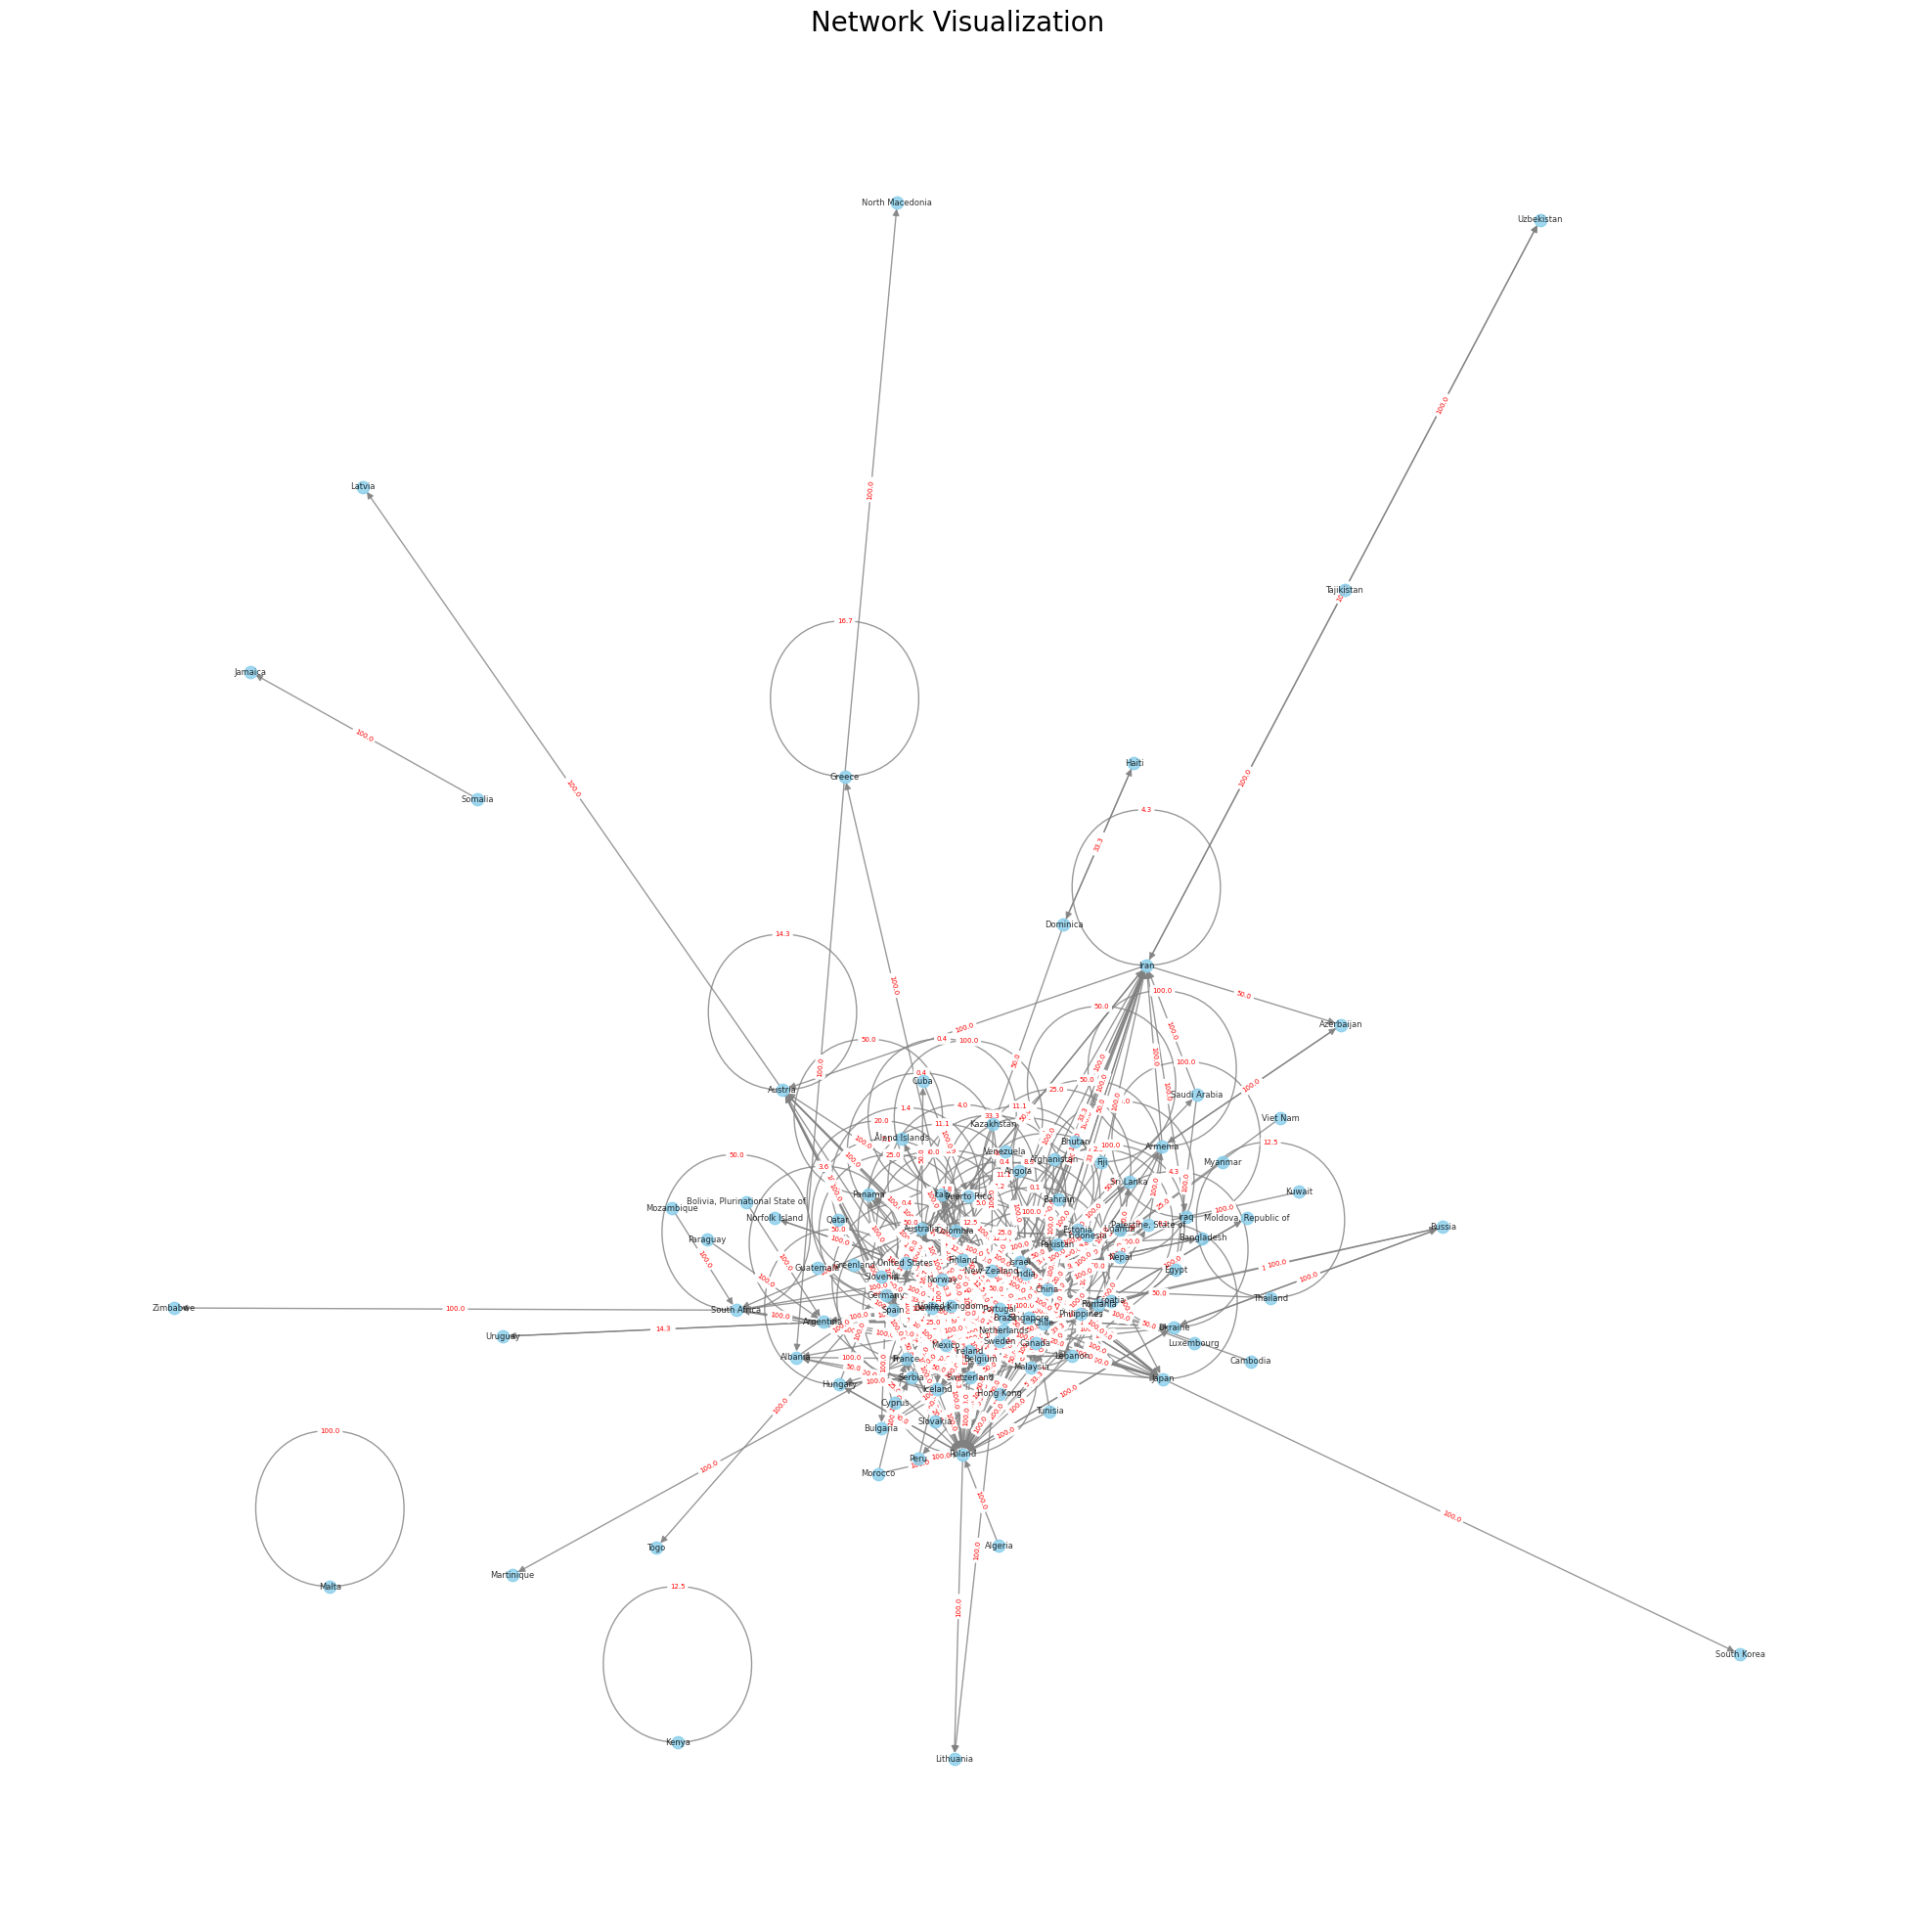

In [98]:
if graph:
    na.plot_country_graph(graph, COUNTRY_CSV_FILENAME)
else:
    print("Graph not loaded, cannot plot country graph.")

### 4. Calculate shortest paths from country to country
The shortest path is calculated using the number of hyperlinks between two subreddits as an inverse edge weight. 

In [99]:
# --- Calculate and save country-to-country shortest paths ---

if all_shortest_paths:
    na.calculate_country_shortest_paths(all_shortest_paths, COUNTRY_CSV_FILENAME, COUNTRY_PATHS_OUTPUT)
else:
    print("Shortest paths not available, cannot calculate country paths.")


Loading country subreddit list...
Loaded 1396 subreddit-to-country mappings.

Finding minimum shortest paths between countries...
  ... processing source subreddit 1/43695 ('yosemitephotography')
  ... processing source subreddit 1000/43695 ('truetruestl')
  ... processing source subreddit 2000/43695 ('freespeechinaction')
  ... processing source subreddit 3000/43695 ('violethand')
  ... processing source subreddit 4000/43695 ('anaalius')
  ... processing source subreddit 5000/43695 ('firewater')
  ... processing source subreddit 6000/43695 ('mediastudies')
  ... processing source subreddit 7000/43695 ('highprofits')
  ... processing source subreddit 8000/43695 ('theduckpile')
  ... processing source subreddit 9000/43695 ('pcmrshitpost')
  ... processing source subreddit 10000/43695 ('tameimpala')
  ... processing source subreddit 11000/43695 ('massivecock')
  ... processing source subreddit 12000/43695 ('progressiveactivism')
  ... processing source subreddit 13000/43695 ('accidental

### 5. Show the final paths.

In [64]:
# Load and display the results from the saved CSV

PATH = "data/"

# Path for the final output file
COUNTRY_PATHS_OUTPUT = os.path.join(PATH, "country_shortest_paths_output.csv")

try:
    df_country_paths = pd.read_csv(COUNTRY_PATHS_OUTPUT)
    df_relevant_rows = df_country_paths[
        (df_country_paths['source_country'] != df_country_paths['target_country']) & (df_country_paths['shortest_path_length'] < np.inf)
    ]
    print("\n--- Shortest Paths Between Countries (Top 10) ---")
    display(df_relevant_rows.head(10))
except FileNotFoundError:
    print(f"Could not find results file at {COUNTRY_PATHS_OUTPUT}")


--- Shortest Paths Between Countries (Top 10) ---


,source_country,target_country,shortest_path_length
9,Pakistan,India,4.545455
11,India,Pakistan,5.000000
12,Israel,"Palestine, State of",5.882353
14,Brazil,Portugal,5.882353
15,United Kingdom,Ireland,5.882353
16,"Palestine, State of",Israel,5.882353
18,India,Nepal,6.666667
20,New Zealand,Australia,7.142857
22,Canada,India,8.104396
25,Japan,India,8.571429
